created June 2023 by Dirk Derichsweiler
# Import Bitnami helm package into EZUA

 In this notebook, our aim is to effectively utilize an existing helm package from Bitnami and import it seamlessly into Ezmeral Unified Analytics.

For reference, we will be utilizing the MySQL package mentioned below.  
https://bitnami.com/stack/mysql/helm

## download package - and untar package

In [ ]:
helm pull oci://registry-1.docker.io/bitnamicharts/mysql --untar

This step will generate a folder named 'mysql' in your current directory.this will create a folder with the name mysql in your current directoy.

Since HPE Ezmeral Unified Analytics Software incorporates ISTIO functionalities, certain modifications are necessary for the existing repository.   
Below are the required steps:

# Define Endpoint

**adapt the following configuration block to your needs and insert into mysql/values.yaml.**

```bash
#Platform related options
ezua:
  oidc:
    client_id: "${OIDC_CLIENT_ID}"
    client_secret: "${OIDC_CLIENT_SECRET}"
    domain: "${OIDC_DOMAIN}"

  domainName: "${DOMAIN_NAME}"
  #Use next options in order to configure the application endpoint.
  #Example of a VirtualService is here:
  virtualService:
    endpoint: "techhours.${DOMAIN_NAME}"
    istioGateway: "istio-system/ezaf-gateway"

  authorizationPolicy:
    namespace: "istio-system"
    providerName: "oauth2-proxy"
    matchLabels:
      istio: "ingressgateway"

```

**the next step configures the kyverno-cluster policy**

In [9]:
# adapt to your needs
cat <<< ' 
apiVersion: kyverno.io/v1
kind: ClusterPolicy
metadata:
  name: add-vendor-app-labels-{{ include "mysql.primary.fullname" . }}
  annotations:
    "helm.sh/hook": pre-install
    "helm.sh/hook-delete-policy": before-hook-creation
spec:
  background: false
  rules:
  - name: add-vendor-app-labels
    match:
      any:
      - resources:
          namespaces:
          - {{ .Release.Namespace }}
          kinds:
          - Pod
    mutate:
      patchStrategicMerge:
        metadata:
          labels:
            hpe-ezua/type: vendor-service
' > mysql/templates/kyverno-cluster-policy.yaml

In [16]:
# adapt to your needs
cat <<< ' 
apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: {{ include "mysql.primary.fullname" . }}
  labels:
    {{- include "primary.podLabels" . | nindent 4 }}
spec:
  gateways:
    - {{ .Values.ezua.virtualService.istioGateway }}
  hosts:
    - {{ .Values.ezua.virtualService.endpoint | required "\nValid .Values.ezua.virtualService.endpoint is required !" }}
  http:
    - match:
        - uri:
            prefix: /
      rewrite:
        uri: /
      route:
        - destination:
            host: {{ include "mysql.primary.fullname" . }}.{{ .Release.Namespace }}.svc.cluster.local
            port:
              number: {{ .Values.service.port }}
' > mysql/templates/virtualService.yaml

In [10]:
# adapt to your needs
cat <<< ' 
apiVersion: security.istio.io/v1beta1
kind: AuthorizationPolicy
metadata:
  name: {{ .Release.Name }}-auth-policy
  namespace: {{ .Values.ezua.authorizationPolicy.namespace }}
spec:
  action: CUSTOM
  provider:
    name: {{ .Values.ezua.authorizationPolicy.providerName }}
  rules:
    - to:
        - operation:
            hosts:
            - {{ .Values.ezua.virtualService.endpoint }}
  selector:
    {{- with .Values.ezua.authorizationPolicy.matchLabels }}
    matchLabels:
      {{- toYaml . | nindent 6 }}
    {{- end }}
' > mysql/templates/authpolicy.yaml

## create helm package

In [15]:
helm package mysql

Successfully packaged chart and saved it to: /home/dderichswei/notebooks/end2end/infrastructure/import-application/mysql-9.10.3.tgz


Next, navigate to the HPE Ezmeral Unified Analytics Software Platform and proceed with importing the package.

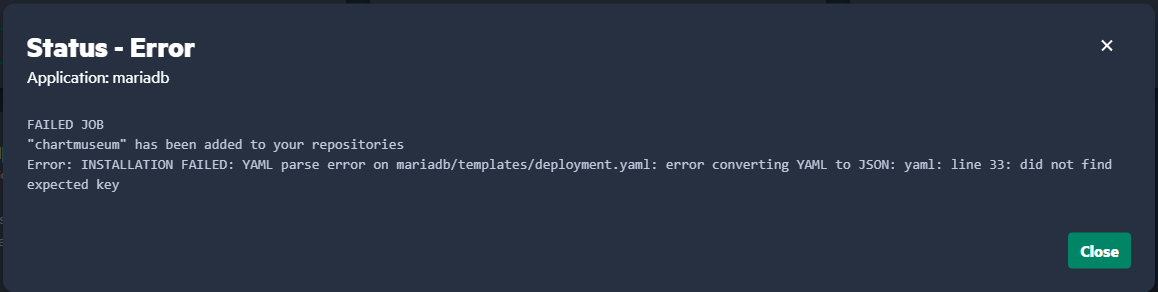


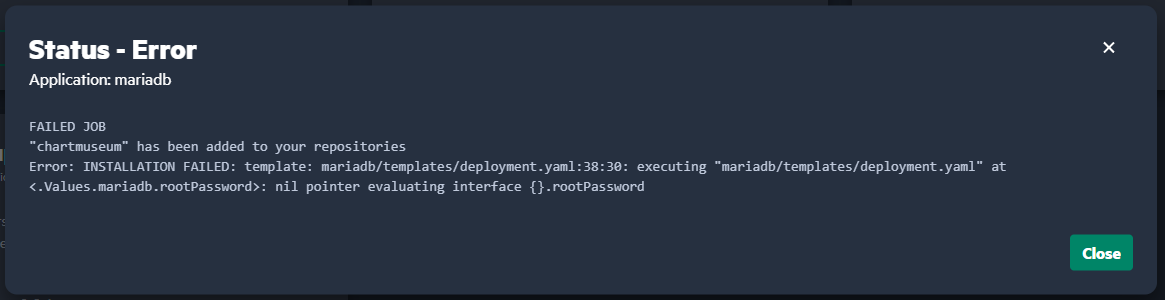

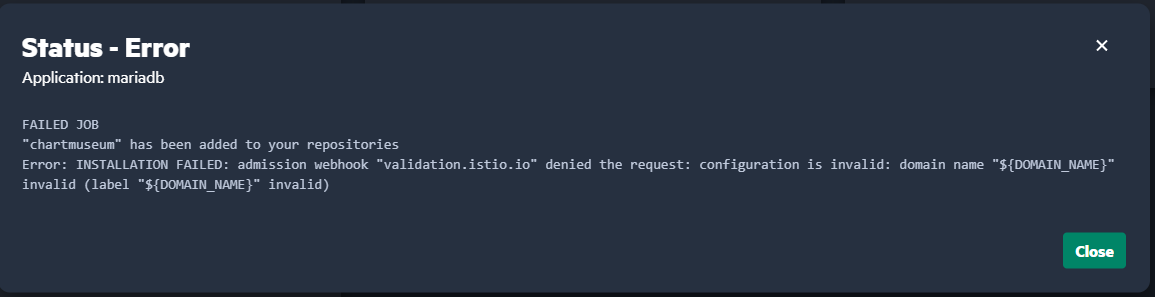

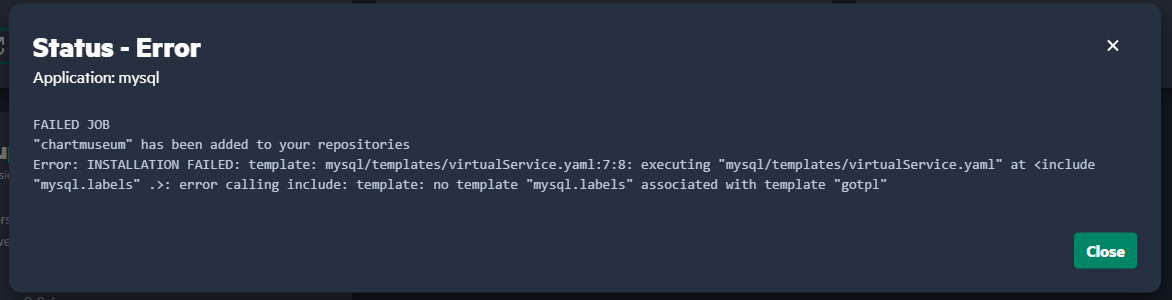